In [1]:
!pip install pyro-ppl
!pip install scikit-optimize

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
#from model import YModel

import matplotlib.pyplot as plt
%matplotlib inline

my_cmap = plt.cm.jet
my_cmap.set_under('white')

To formulate an optimisation problem, one starts with the definition of the function to be minimised We define the objective function $R(\psi)$ as a function that depends on the parameter vector $\psi$. This function returns a number that in some way characterises the performance of the optimised object (e.g. the total flux of particles through the detector). Thus, the goal of the optimisation is to find a $\psi^*$ that minimises the objective function:

$$
\psi^{*} = argmin_{\psi} R(\psi)
$$

As an example, let the objective function be the 1-dimensional Higgs potential:

\begin{equation}
    R(\psi) = -5 \psi^2 + \psi^4
\end{equation}

In this simple scenario, one can find the minimum analytically. There are two degenerate minima at $\psi^* = \pm \sqrt{5/2}$.

In [3]:
def hat(x):
    return -5 * x**2 + x**4

def hat_derivative(x):
    return -10 * x + 4 * x** 3

def hat_numpy(x):
    return (-5 * np.array(x)**2 + np.array(x)**4)[0]

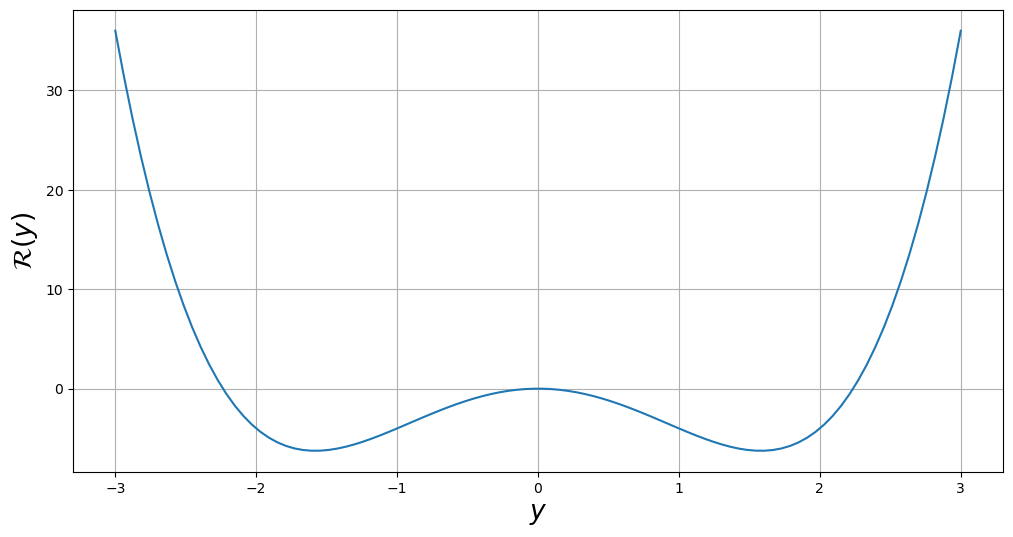

In [4]:
plt.figure(figsize=(12,6))
rang = np.linspace(-3, 3, 100)
plt.plot(rang, hat(rang))

plt.xlabel(r"$y$", fontsize=19)
plt.ylabel(r"$\mathcal{R}(y)$",fontsize=19)
plt.grid()

However, such a simple function does not resemble what one actually observes in a simulation or experiment. For example, in an experiment there will always be some noise observed. In a simulator, one often does not even know the exact dependency of the loss on the inputs.

For instance, the parameters $\psi$ may be treated as unknown, yet affect the value of the observables $y$. The observable $y$ may be a random variable, sampled from a normal distribution with mean equal to $\psi$ and fixed standard deviation $\sigma$:  $y \sim N(y; \psi, \sigma)$. Now, the objective function $R$ depends on $\psi$ implicitly: the only variable that we actually observe is $y$:

\begin{equation}
    R(y) = -5 y^2 + y^4,\quad \text{s.t.}  \ \ y \sim \mathscr(y; \psi, \sigma)
\end{equation}


Such formulation results in a distribution over values of $R$ as a function of $\psi$, rather than an exact value, as in the initial example. The corresponding plot of the mean and the standard deviation of $R(\psi)$ is shown in.

For the purpose of this exercise, we are going to use Pyro package, a powerful package for probabilistic programming. It allows for automatic differentiation through various probabilistic models and we are going to use this property to optimise our function.

In [5]:
psi = torch.linspace(-3, 3, 1000)
NOISE = 0.2

def sample_y(psi):
    """
    We define y \sim N(psi, \sigma) as above.
    """
    y_dist = dist.Normal(psi, NOISE)
    y = pyro.sample('y', y_dist)
    return hat(y)

def sample_y_numpy(psi):
    """
    Same as above, but returns numpy
    """
    if isinstance(psi, float) or isinstance(psi, int):
        psi = [psi]
    y_dist = dist.Normal(torch.Tensor(psi), NOISE)
    y = pyro.sample('y', y_dist)
    return hat(y.numpy())

def sample_y_derivative_numpy(psi):
    if isinstance(psi, float) or isinstance(psi, int):
        psi = [psi]
    y_dist = dist.Normal(torch.Tensor(psi), NOISE)
    y = pyro.sample('y', y_dist)
    return hat_derivative(y.numpy())

def sample_single_value(psi):
    return sample_y_numpy(psi)[0]
    

y = sample_y(psi)

Since $R$ is a random variable now, it is natural to reformulate the optimisation problem in terms of the expected value of the function: 

\begin{equation}
     \psi^{*} = argmin_{\psi} E_{p(y;\psi, \sigma)}[R(y)]
\end{equation}

Now, lets see how the actual noisy function will look like. Because it is stochastic now, we will plot the mean value of $R$ and $1 \sigma$ interval.

In [6]:
stds = []
means = []
_range = torch.linspace(-3, 3, 100)
for psi in _range:
    std = sample_y(psi.repeat([1000])).std()
    stds.append(std.item())
    mean = sample_y(psi.repeat([1000])).mean()
    means.append(mean.item())
stds = np.array(stds)
means = np.array(means)

(-7.0, 10.0)

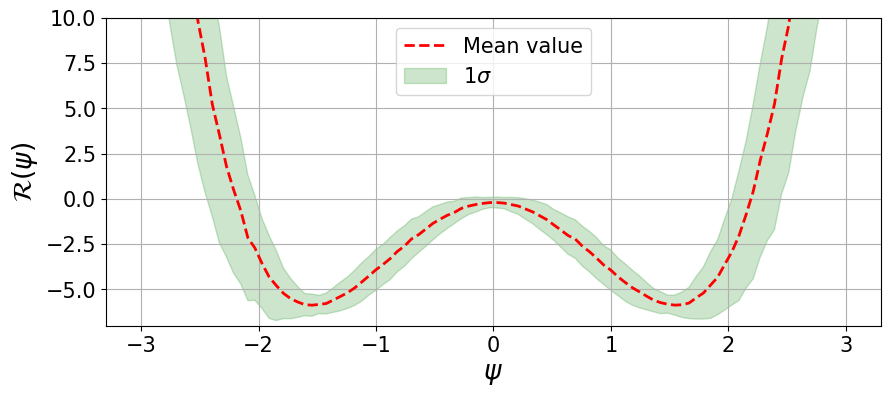

In [7]:
plt.figure(figsize=(10,4))
plt.plot(_range, means, '--', c='r', linewidth=2, label="Mean value")
plt.fill_between(_range, means - stds, means+stds, alpha=0.2, color='green', label=r"$1\sigma$")


plt.grid()
plt.legend(fontsize=15)
plt.xlabel(r"$\psi$", fontsize=19)
plt.ylabel(r"$\mathcal{R}(\psi)$",fontsize=19)
plt.gca().tick_params(axis='both', labelsize= 15)
plt.gca().tick_params(axis='both', labelsize= 15)


plt.ylim(-7,10)

In [10]:
# Plot true function.
def plot_base():
    plt.plot(_range, hat(_range), '--', c='r', linewidth=2, label="True function")


    plt.grid()
    #plt.legend()
    plt.xlabel(r"$\psi$", fontsize=15)
    plt.ylabel(r"$\mathcal{R}(\psi)$",fontsize=15) 
    plt.ylim(-7,10)

def plot_grads(x_history, func_history, derivatives, index):
    b = func_history[index] - derivatives[index] * x_history[index]
    
    dx=0.2
    plt.arrow(x_history[index] + dx,
              derivatives[index] * (x_history[index] + dx) + b,
              dx/4, derivatives[index] * dx/4, zorder=10, width=0.03, color='g')
    plt.plot([x_history[index], x_history[index] + dx], [derivatives[index] * x_history[index] + b,
                        derivatives[index] * (x_history[index] + dx) + b], '-', linewidth=1.5, label='Derivative', c='g')    
    
def plot_history(func_history):
    plt.plot(range(len(func_history)), func_history)
    plt.grid()
    plt.xlabel(r"iteration", fontsize=15)
    plt.ylabel(r"$\mathcal{R}(\psi)$",fontsize=15)
#     plt.gca().tick_params(axis='both', labelsize= 15)
#     plt.gca().tick_params(axis='both', labelsize= 15)    

# Tractable derivative

Remember, because we are using Pyro and because this this a toy problem, we actually have access to our gradeints!
So we can perform optimisation using PyTroch

In [11]:
def SGD_pyro(func, x_init, n_iter=15, alpha=0.1):
    x_history = []
    func_vals = []
    derivatives = []    
    x = torch.tensor([x_init], requires_grad=True)
    
    for index in range(n_iter):
        func_value = func(x)
        func_value.backward()
        x_new = x - alpha * x.grad.data
        derivatives.append(x.grad.data.item())
        x_history.append(x.item())
        func_vals.append(func_value.item())
        x.data = x_new
    return x_history, func_vals, derivatives

In [12]:
N_ITER = 40
x_history, func_history, derivatives = SGD_pyro(sample_y, 0., alpha=0.005, n_iter=N_ITER)

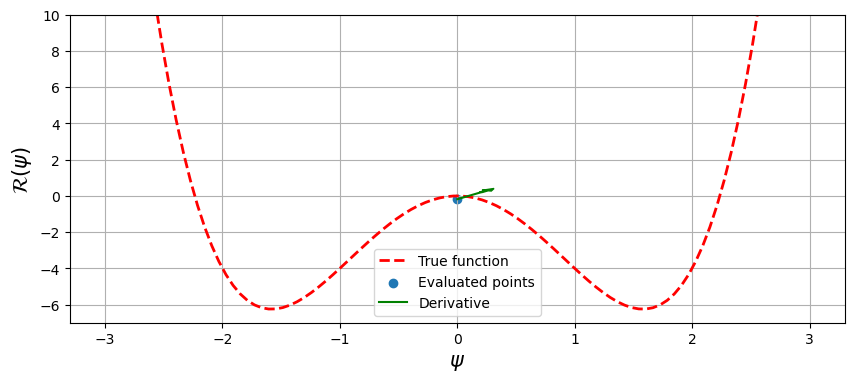

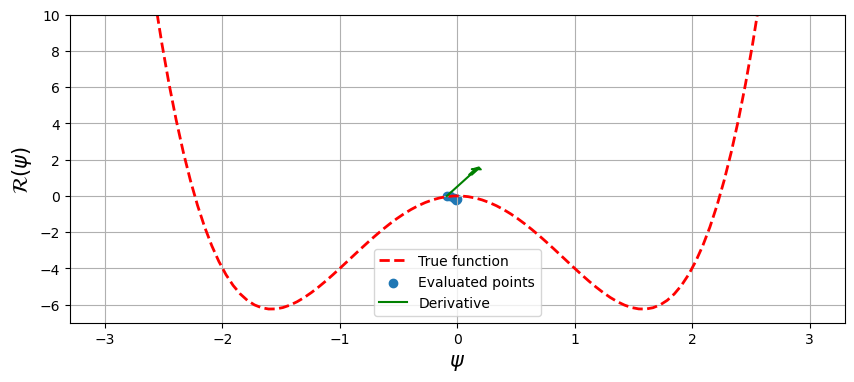

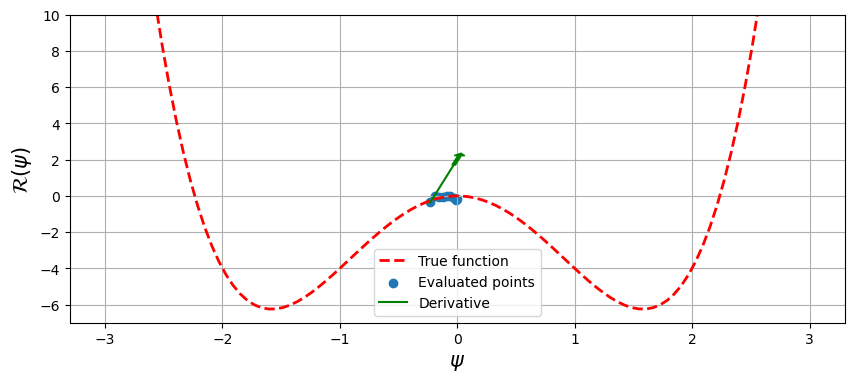

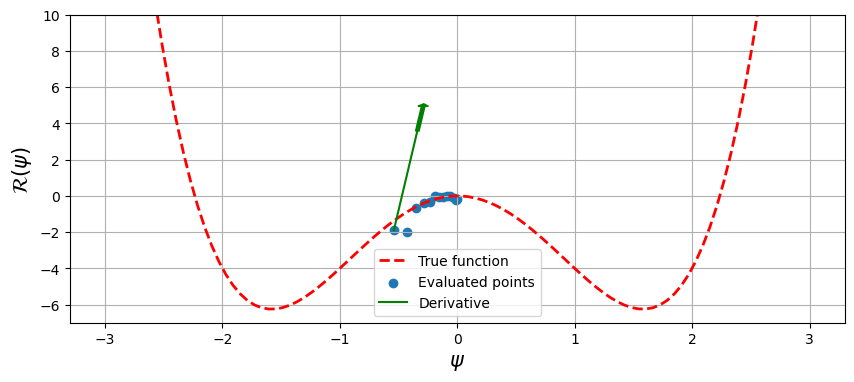

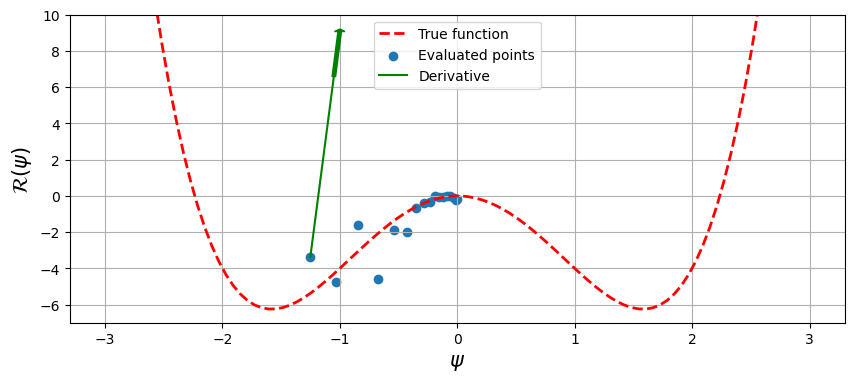

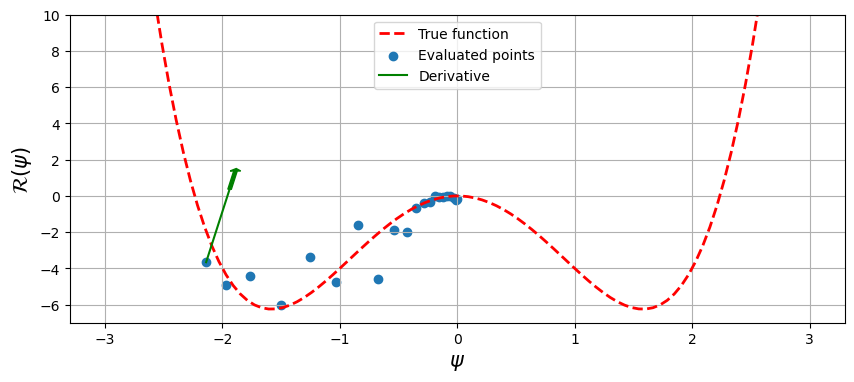

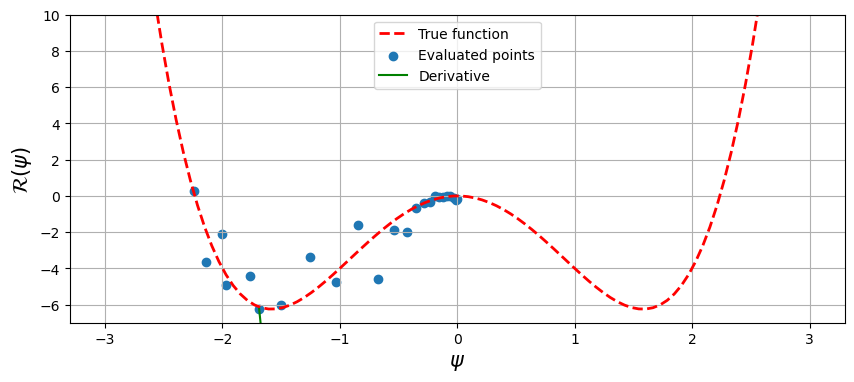

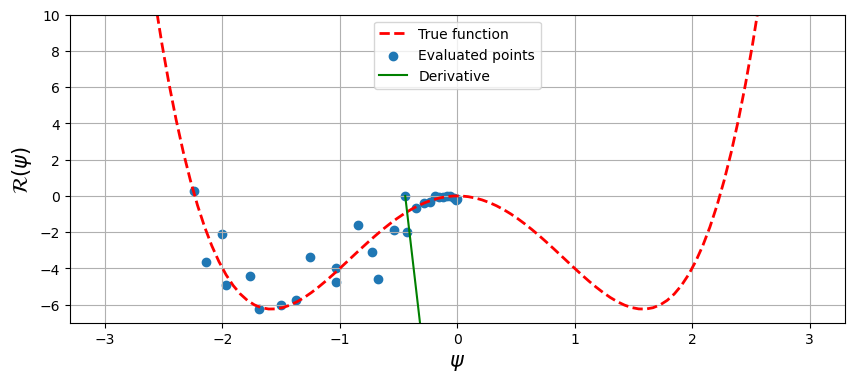

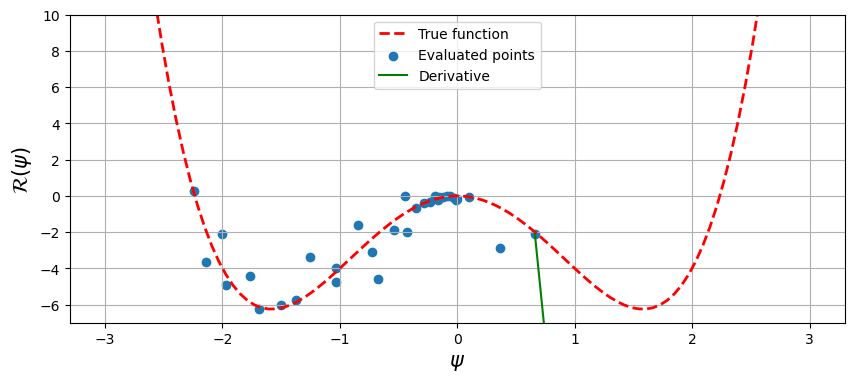

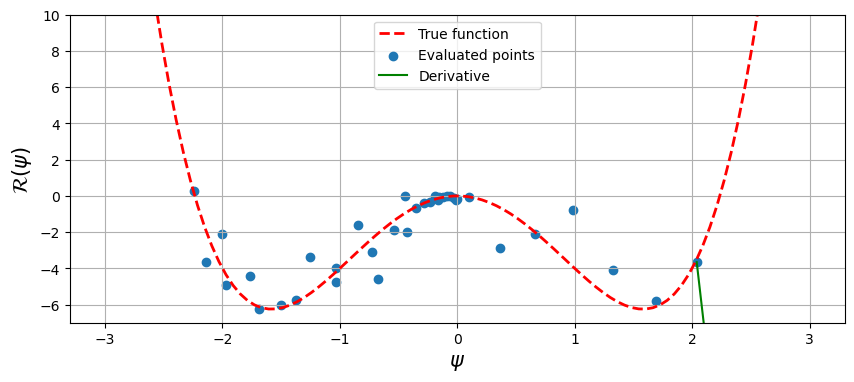

In [13]:
step = 4
n_plots = N_ITER // step

for index in range(1, N_ITER+1, step):
    plt.figure(figsize=(10,4))
    plot_base()
    plt.scatter(x_history[:index], func_history[:index], label='Evaluated points')
    plot_grads(x_history, func_history, derivatives, index-1)
    plt.legend()

# Numerical differentiation

Now, in reality, we would not be able to use Pyro to compute gradients. Moreover, we will not be able to compute derivative analytically.

You should write a function that returns a numerical derivative of any input, given the step $h$:

$$
f'(x) = \frac{f(x+h) - f(x-h)}{2h}
$$

In [14]:
def num_derivative(func, x, step):
    # Your code here.
    return (func(x+step) -func(x-step)) / (2 * step)

Now, use that function to perforom SGD optimisation.

In [45]:
def SGD(func, x_init, n_iter=15, alpha=0.06, step=0.1):
    x_history = [x_init]
    func_vals = [func(x_init)]
    derivatives = []
    x = x_init
    
    for index in range(n_iter):
        derivative = num_derivative(func, x, step)
        derivatives.append(derivative)

        x_new = x - func(x) / derivative
        x_history.append(x_new)
        func_vals.append(func(x_new))
        x = x_new
    return x_history, func_vals, derivatives

In [46]:
N_ITER = 20 # your number
x_history, func_history, derivatives = SGD(sample_y, 0, alpha=0.05, n_iter=N_ITER)

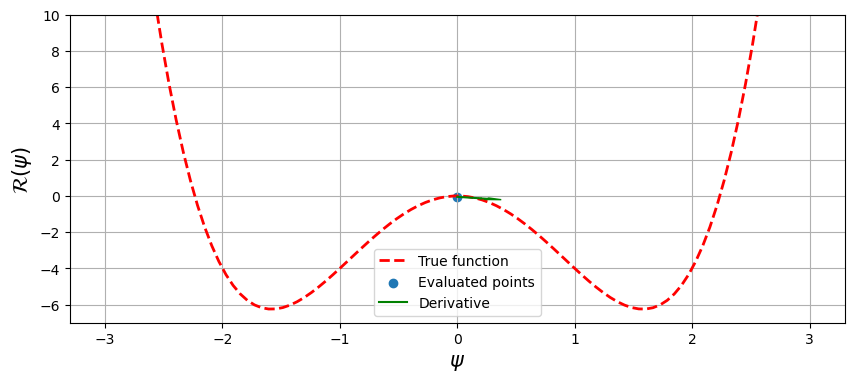

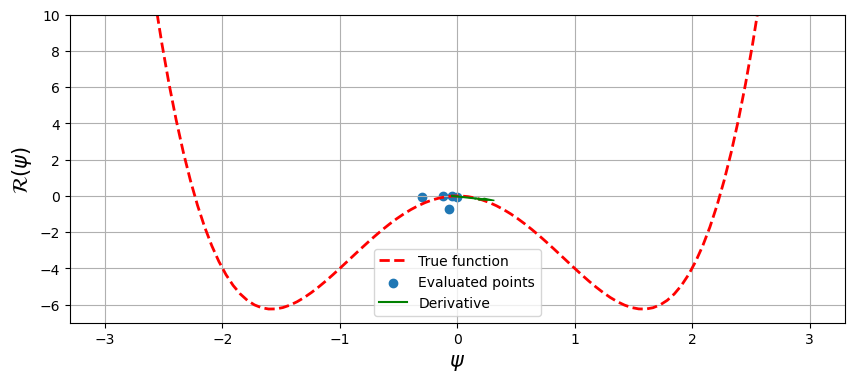

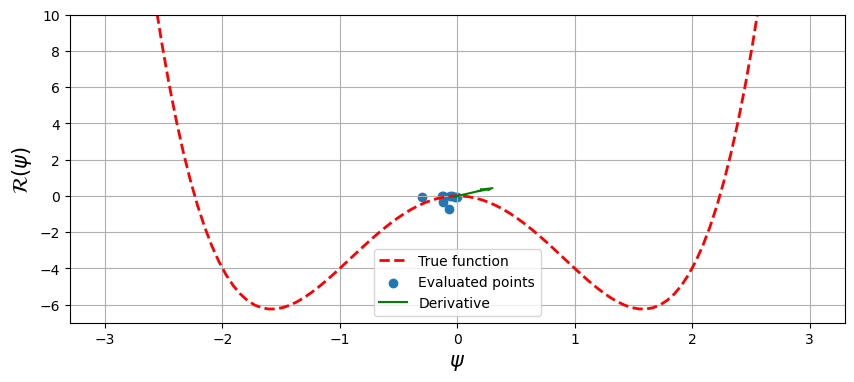

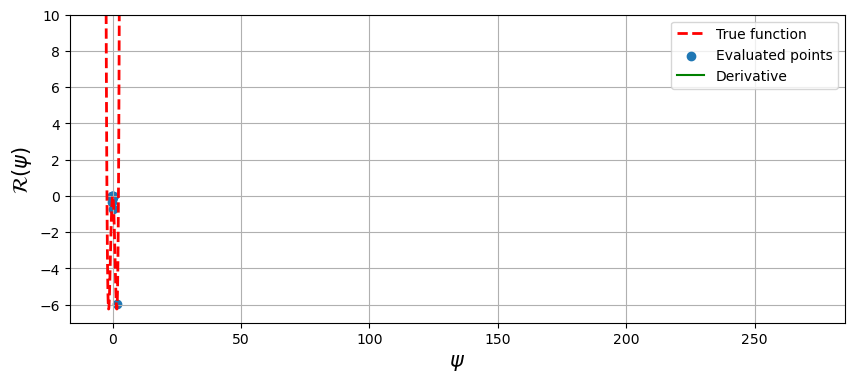

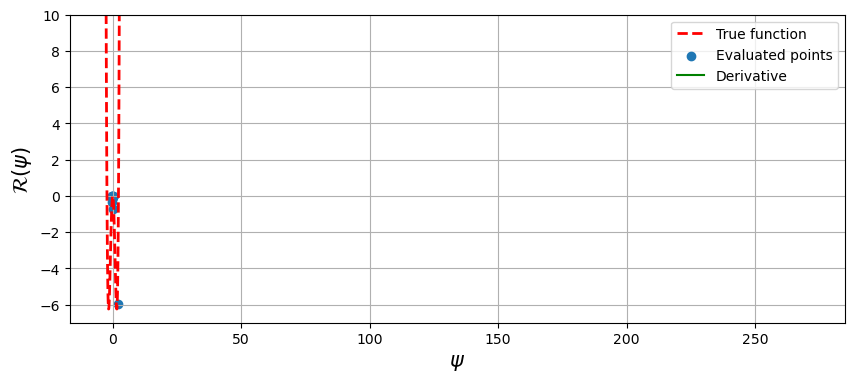

In [47]:
step = 4
n_plots = N_ITER // step

for index in range(1, N_ITER+1, step):
    #plt.subplot(n_plots+1, 1, index)
    plt.figure(figsize=(10,4))
    plot_base()
    plt.scatter(x_history[:index], func_history[:index], label='Evaluated points')
    plot_grads(x_history, func_history, derivatives, index-1)
    plt.legend()

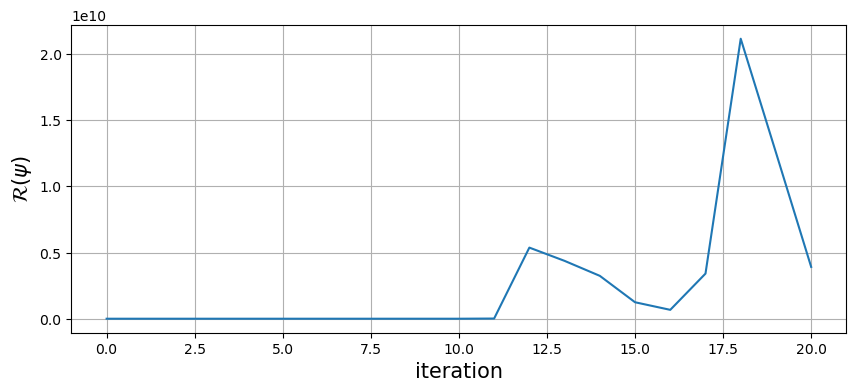

In [48]:
plt.figure(figsize=(10,4))
plot_history(func_history)

# Bayesian optimisation

Here, we are going to use scikit optimisation package (https://scikit-optimize.github.io/stable/).
It has a number of optimisation methods for Bayesian optimisation, and bayesian parameter grid search. It is good for quick prototyping but is quite slow and not actively supported.

We are going to look at the BO with Gaussian processes, and visualise convergence plot.

In [ ]:
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_gaussian_process

In [ ]:
N_ITER=20
res = gp_minimize(sample_single_value,                  # the function to minimize
                  [(-50.0, 100.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=N_ITER,         # the number of evaluations of f
                  n_initial_points=1, # the number of random initialization points
                  n_restarts_optimizer=1,
                  noise=0.01**2,       # the noise level (optional)
                  random_state=1234) 
plot_convergence(res);

In [ ]:
res.x, res.fun

What did you observe? Was the algorithm able to attain minima? If not, why?

Look at the parameters of our optimiser function and think which of them seems to affect the results the most? 

In [ ]:
#plt.rcParams["figure.figsize"] = (8, 14)
for index, n_iter in enumerate([1, 5, 14]):
    # Plot true function.
    plt.figure(figsize=(18,6))
    plt.subplot(1, 2, 1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False
    show_legend = False
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=hat_numpy,
                               noise_level=0,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    
    
    plt.legend(fontsize=15)
    plt.xlabel(r"$\psi$", fontsize=19)
    plt.ylabel(r"$\mathcal{R}(\psi)$",fontsize=19)
    plt.gca().tick_params(axis='both', labelsize= 15)
    plt.gca().tick_params(axis='both', labelsize= 15)    
    
    # Plot EI(x)
    plt.subplot(1, 2, 2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    plt.legend(fontsize=15)
    plt.xlabel(r"$\psi$", fontsize=19)
    plt.ylabel(r"EI $(\psi)$",fontsize=19)
    plt.gca().tick_params(axis='both', labelsize= 15)
    plt.gca().tick_params(axis='both', labelsize= 15)    
    plt.savefig("BO_{}.pdf".format(index), bbox_inches='tight', dpi=100)

#plt.show()

# Evolutionary algorithms

Evolutionary algorithms are inspired by an evlution of spicies in biology. Usually, they iterate between sampling new points, evaluating functions, changing ("mutating") the obtained points and evaluating the function again.

Now implement the simlpliest Gaussian evolutionary algorithm discussed during the lecture:

- Sample $N$ $\psi$ points from any distribution.
- Evaluate our function
- Select the best $K$ points
- Update the parameters of the distribution

Repate for **N_ITER** number of steps.

In [ ]:
def evolutionary_algorithm(func, N=10, K=3, mean=0):
    best_psi = []
    best_func = []
    for i in range(N_ITER):
        samples = # Your code
        func_samples = sample_y_numpy(samples)
        sorted_ind = # Your code
        elite = # Your code
        # Update parameters of the distributions (mean)
        
        if not best_func or func_samples[sorted_ind][0] < best_func[-1]:
            best_psi.append(samples[0])
            best_func.append(func_samples[sorted_ind][0])
        else:
            best_psi.append(best_psi[-1])
            best_func.append(best_func[-1])
        
        
        if i % 5 == 0:
            plt.figure(figsize=(10,4))
            plot_base()
            #plt.grid()
            plt.scatter(samples, func_samples, c='black', s=25)
            plt.scatter(elite, func_samples[sorted_ind], c='b', s=25)
            plt.title(f"Iteration: {i}")
    return best_psi, best_func

In [ ]:
best_psi, best_func = evolutionary_algorithm(sample_y_numpy)

In [ ]:
plt.plot(range(len(best_func)), best_func, ".-", markersize=10)
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Function value")

# REINFORCE gradient estimation

In this exercise we would like to explore the REINFORCE approach, discussed at the lecture. To do that, we will introduce a distribution over parameters $\psi$. Lets assume that

$$
\psi \sim N(\mu, \sigma)
$$

but we will only be optimising w.r.t to $\mu$.

Recall, that when we use the REINFORCE approach, the gradient estimator for the objective becomes:

$$
      \nabla_{\psi} E_{p(y;\psi, \sigma)}[R(y)] \approx \nabla_{\psi} E_{p(\psi;\mu, \sigma)}[R(y)]
      = E_{p(\psi;\mu, \sigma)}[R(y) \nabla_{\mu} log p(\psi;\mu,\sigma)]
$$

Compute the derivative: $\nabla_{\mu} log p(\psi;\mu, \sigma)$ = ?

Once we have the derivative, lets write an SGD loop, using the REINFORCE estimator.

In [ ]:
def compute_reinforce_grad(func, mu, n_samples=1, scale=1.):
    """
    func: optimised function
    mu: paramter w.r.t which we take gradients
    n_samples: number of samples to estimate expectation
    scael: scale of normal distribution of psi
    """
    # Sample psi from Normal
    # compute func value at sampled points
    # compute grad log p(\psi) at sampled point
    # compute REINFORCE estimate  

In [ ]:
def SGD_reinforce(func, x_init, n_iter, alpha=0.06, n_samples=1, scale=1.):
    x_history = [x_init]
    func_vals = [func(x_init)]
    derivatives = []
    x = x_init
    
    for index in range(n_iter):
        derivatives.append(compute_reinforce_grad(func, x, n_samples=n_samples, scale=scale))
        x_new = x - alpha * derivatives[-1]
        x_history.append(x_new)
        func_vals.append(func(x_new))
        x = x_new
    return x_history, func_vals, derivatives

In [ ]:
N_ITER=30
x_history, func_history, derivatives = SGD_reinforce(sample_y_numpy, 0, n_iter=N_ITER, alpha=0.03, n_samples=2)

In [ ]:
step = 4
n_plots = N_ITER // step

for index in range(1, N_ITER+1, step):
    #plt.subplot(n_plots+1, 1, index)
    plt.figure(figsize=(10,4))
    plot_base()
    plt.scatter(x_history[:index], func_history[:index], label='Evaluated points')
    plot_grads(x_history, func_history, derivatives, index-1)
    plt.legend()

In [ ]:
plt.figure(figsize=(10,4))
plot_history(func_history)

Did it work? If not, which parameters we might want to change to make the algorithm converge?

# Take home message

There is a plethora of algorithms available for black-box optimisation. All of them may be applied to the same problem. All of them might provide satisfactory results, but the quality of the results and the speed on convergence might differ orders of magnitude. So it is impoortant to choose the algorithm according to the problem at hand.

For example, if the problem is high dimensional, it might make sense to start with the application of BO and after some number of iterations switch to gradient-based methods.
If nothing works, think about where is the bottleneck of the underlying problem and if the existing algorithms can be modified to bypass the bottleneck.

It is also crucial to understand the underlying assumptions of each optimisation algorithm and choose the hyperparameters according to the task. For example, in BO one wants to specify the search space so that the hypothetical minima would be located near the centre of the search space.